In [1]:
import collections
import copy
import functools
import itertools

import numpy as np
from typing import List, Iterable, Any, Union, Optional, overload
import matplotlib.pyplot as plt
import sympy
import networkx as nx
from scipy.linalg import dft
from tqdm import notebook

In [14]:
import linear_regression as lr
import sparse_factorization as sf
import topology as topo

# Doubly stochastic hierarchically banded (DSHB) factorization algorithm

In [9]:
n = 43
n_sub = [32, 8, 3]
n_sub_facts = [[2,2,2,2,2], [2,2,2], [3]]
max_period = max(len(fact) for fact in n_sub_facts)

for sub, sub_facts in zip(n_sub, n_sub_facts):
    assert sub == np.prod(sub_facts)

In [10]:
def consensus(x):
    return np.linalg.norm(x - np.mean(x), ord=2)

In [11]:
def get_mse_dshb(n_sub, n_sub_facts, seed=123):
    np.random.seed(seed)
    n = sum(n_sub)
    x = np.random.randn(n)
    full_list = sf.get_all_sds_matrices(n_sub, n_sub_facts)
    mse_list = []
    mse_list.append(consensus(x))
    for A in full_list:
        x = A @ x
        mse_list.append(consensus(x))
    return np.asarray(mse_list) / mse_list[0]


In [12]:
def get_mse_exp(size, iters, seed=123):
    np.random.seed(seed)
    x = np.random.randn(n)
    mse_list = []
    mse_list.append(consensus(x))
    for i in range(iters):
        A = topo.dynamic_exp2(i, size=n)
        x = A @ x
        mse_list.append(consensus(x))
    return np.asarray(mse_list) / mse_list[0]

<Figure size 1000x500 with 0 Axes>

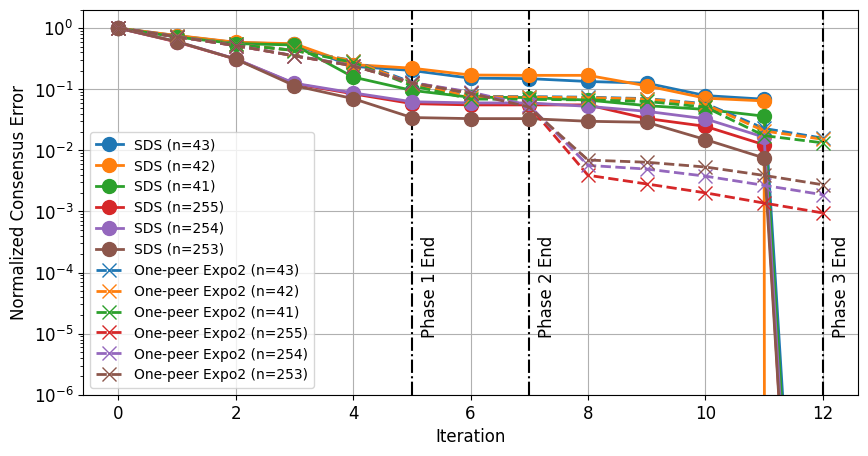

In [13]:
def generate_test_case():
    n_sub = [32, 8, 3]
    n_sub_facts = [[2,2,2,2,2], [2,2,2], [3]]
    yield n_sub, n_sub_facts
    
    n_sub = [32, 8, 2]
    n_sub_facts = [[2,2,2,2,2], [2,2,2], [2]]
    yield n_sub, n_sub_facts
    
    n_sub = [32, 6, 3]
    n_sub_facts = [[2,2,2,2,2], [3, 2], [3]]
    yield n_sub, n_sub_facts
    
    n_sub = [243, 9, 3]
    n_sub_facts = [[3, 3, 3, 3, 3], [3, 3], [3]]
    yield n_sub, n_sub_facts

    n_sub = [243, 8, 3]
    n_sub_facts = [[3, 3, 3, 3, 3], [2, 2, 2], [3]]
    yield n_sub, n_sub_facts
    
    n_sub = [243, 8, 2]
    n_sub_facts = [[3, 3, 3, 3, 3], [2, 2, 2], [2]]
    yield n_sub, n_sub_facts

plt.figure(figsize=(10, 5))
plt.rc('font', size=12) 
plt.rc('legend', fontsize=10)
# DSHB
plot_phase=True
for n_sub, n_sub_facts in generate_test_case():
    n = sum(n_sub)
    max_period = max(len(fact) for fact in n_sub_facts)
    for sub, sub_facts in zip(n_sub, n_sub_facts):
        assert sub == np.prod(sub_facts)
    
    consensus_error = get_mse_dshb(n_sub, n_sub_facts)
    plt.semilogy(consensus_error, label=f"SDS ({n=})", marker="o", linewidth=2, markersize=10)
    if plot_phase:
        plt.axvline(max_period,  linestyle="-.", color="black")
        plt.text(max_period + 0.15, 1e-5, 'Phase 1 End', fontsize=12, rotation="vertical")
        plt.axvline(max_period + len(n_sub) - 1,  linestyle="-.", color="black")
        plt.text(max_period+ len(n_sub) - 1 + 0.15, 1e-5, 'Phase 2 End', fontsize=12, rotation="vertical")
        plt.axvline(max_period *2 + len(n_sub) -1,  linestyle="-.", color="black")
        plt.text(max_period *2 + len(n_sub) -1 + 0.15, 1e-5, 'Phase 3 End', fontsize=12, rotation="vertical")
        plot_phase = False

# Dyn_exp2
for i, n in enumerate([43, 42, 41, 255, 254, 253]):
    consensus_error = get_mse_exp(n, iters=12)
    plt.semilogy(consensus_error, '--', label=f"One-peer Expo2 ({n=})", marker="x", linewidth=2, markersize=10,
                 color=f"C{i}")

plt.ylim(1e-6, 2e0)
plt.xlabel("Iteration")
plt.ylabel("Normalized Consensus Error")
plt.grid(True)
plt.legend()
plt.show()

# DSHB + LR

In [12]:
dimension = 50
num_workers = 253
num_data = num_workers * 100
noise_level = 0.1
As, bs, x_opt = lr.generate_linear_regression_data(
    num_data, dimension, num_workers, noise_level
)
 

In [13]:
def gradient_tracking(graph_generator, eta = 0.0007, alpha = 1, max_iters = 1000, reg = 0, noise=False):
  mse = []

  x_prev = np.zeros((dimension, num_workers))
  x_curr = np.zeros((dimension, num_workers))
  g_curr = np.zeros((dimension, num_workers))
  for a in range(num_workers):
    g_curr[:, [a]] = alpha * lr.grad_fn_agent(x_curr[: ,[a]], As, bs, a, reg, noise)

  for ite in notebook.tqdm(range(max_iters)):
    mse.append(np.linalg.norm(x_curr-x_opt)/np.linalg.norm(x_opt))
    W = graph_generator(ite)

    for a in range(num_workers):
      x_curr[:, [a]] = x_prev[:, [a]] - eta *  g_curr[:, [a]]
    x_curr = x_curr @ W.T

    g_curr = g_curr @ W.T     # Semi-ATC-GT does not mix the gradients.
    for a in range(num_workers):
        y_curr = lr.grad_fn_agent(x_curr[: ,[a]], As, bs, a, reg, noise)
        y_prev = lr.grad_fn_agent(x_prev[: ,[a]], As, bs, a, reg, noise)
        g_curr[:, [a]] = g_curr[:, [a]] + alpha * (y_curr - y_prev)

    x_prev = x_curr.copy()
  return mse

In [14]:
graph_generator=functools.partial(topo.dynamic_exp2, size=num_workers)
mse = gradient_tracking(graph_generator)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [15]:
n_sub = [243, 8, 2]
n_sub_facts = [[3, 3, 3, 3, 3], [2, 2, 2], [2]]
assert sum(n_sub) == num_workers
full_list, A_full = get_all_matrix(n_sub, n_sub_facts)

def graph_generator2(ite):
    N = len(full_list)
    return full_list[ite % N]

mse2 = gradient_tracking(graph_generator2)

  0%|          | 0/1000 [00:00<?, ?it/s]

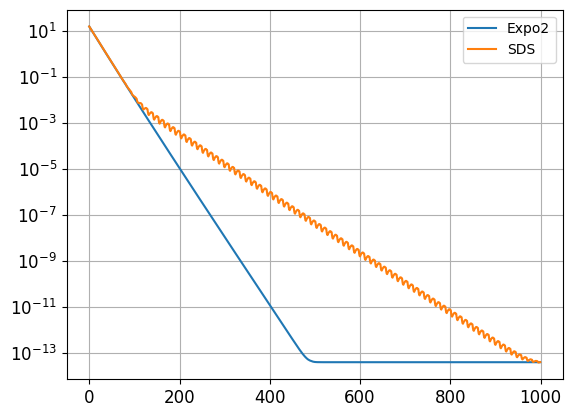

In [16]:
plt.semilogy(mse, label="Expo2")
plt.semilogy(mse2, label="SDS")
plt.legend()
plt.grid(True)
plt.show()